<a href="https://colab.research.google.com/github/tongrabbit/covidSentiment/blob/main/GRU%20-covid19%20tweet%20sentiment%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [ ]:
# 데이터 준비하기
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text/Corona_NLP_train.csv', encoding='latin_1')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text/Corona_NLP_test.csv', encoding='latin_1')

In [ ]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


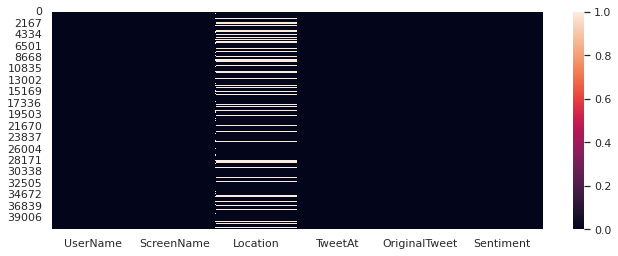

In [ ]:
sns.heatmap(train_data.isnull());

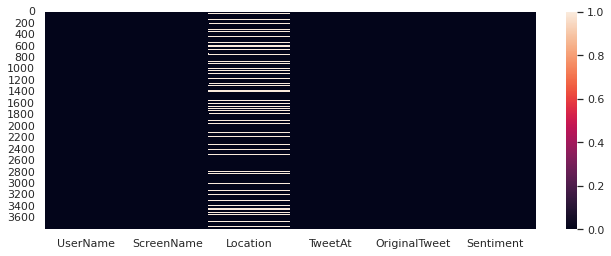

In [ ]:
sns.heatmap(test_data.isnull());

In [ ]:
train_data.drop_duplicates(inplace= True) # 중복데이터 삭제
test_data.drop_duplicates(inplace=True)

In [ ]:
train_data.dropna(inplace=True) # 결측치 삭제
test_data.dropna(inplace=True)

In [ ]:
train_df = train_data.copy()
test_df = test_data.copy()

In [ ]:
print(train_df.isnull().sum()) # null값 확인
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [ ]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [ ]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


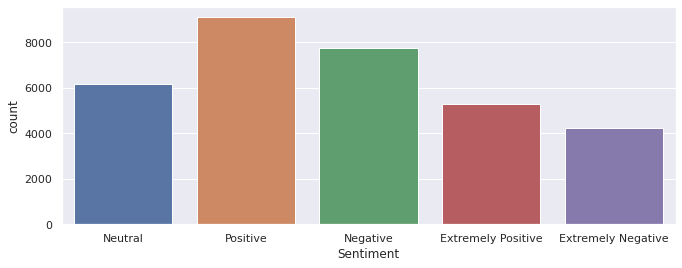

In [ ]:
sns.countplot(train_df['Sentiment']) # 감정 데이터 시각화

In [ ]:
train_df.shape, test_df.shape 

((32567, 6), (2964, 6))

In [ ]:
#  Extremely Positive은 positive로 Extremely Negative는 negative로 변경
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [ ]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


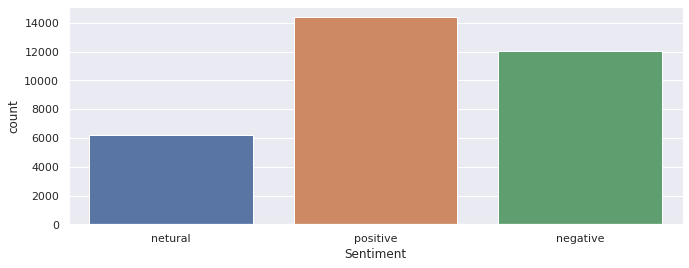

In [ ]:
sns.countplot(train_df['Sentiment']) # 데이터 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


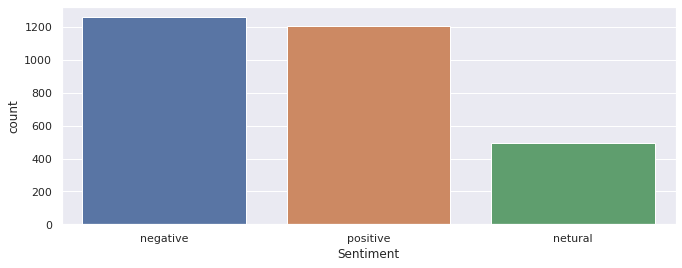

In [ ]:
sns.countplot(test_df['Sentiment'])# 데이터 시각화

In [ ]:
# 데이터 클리닝 
nltk.download('stopwords') 
stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 불필요한 단어 제거
def clean(text):

    text = re.sub(r'http\S+', " ", text)

    text = re.sub(r'@\w+',' ',text)

    text = re.sub(r'#\w+', ' ', text)

    text = re.sub(r'\d+', ' ', text)

    text = re.sub('r<.*?>',' ', text)
    
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [ ]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,netural
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news regionÂs first confirmed COVID- case ...,positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier grocery store sharing insights To prov...,positive


In [ ]:
#  "OriginalTweet" and "Sentiment" 만 추출
df_train = train_df.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [ ]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


감정타입을 맵핑 해준다.
### sentiment 
### 0: Netural
### 1: Positive 
### 2: Negative 

In [ ]:
l = {"netural":0, "positive":1,"negative":2}

In [ ]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [ ]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


In [ ]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [ ]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

In [ ]:
max_len = np.max(x_train.apply(lambda x :len(x))) # 문자열 최대값 

In [ ]:
max_len

286

In [ ]:
tokenizer = Tokenizer()

In [ ]:
# 토큰화
tokenizer.fit_on_texts(x_train) 
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train) 
x_test = tokenizer.texts_to_sequences(x_test)
# 토큰화된 텍스트를 패딩 사이즈에 맞추기
x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post') 

In [ ]:
print(tokenizer.word_index) # 단어 사이즈는 31,759 

{'covid': 1, 'i': 2, 'prices': 3, 'store': 4, 'food': 5, 'supermarket': 6, 'grocery': 7, 'amp': 8, 'people': 9, 'consumer': 10, 'the': 11, 'online': 12, 'shopping': 13, 'get': 14, 'pandemic': 15, 'need': 16, 'workers': 17, 'panic': 18, 'time': 19, 'demand': 20, 'like': 21, 'us': 22, 'we': 23, 'home': 24, 'go': 25, 'coronavirus': 26, 'sanitizer': 27, 'help': 28, 'hand': 29, 'this': 30, 'one': 31, 'going': 32, 'stock': 33, 'due': 34, 'new': 35, 'buying': 36, 'crisis': 37, 'in': 38, 'please': 39, 'if': 40, 'you': 41, 'work': 42, 'it': 43, 'a': 44, 'oil': 45, 'toilet': 46, 'paper': 47, 'local': 48, 'via': 49, 'stay': 50, 'today': 51, 'keep': 52, 'stores': 53, 'shelves': 54, 'many': 55, 'buy': 56, 'still': 57, 'see': 58, 'delivery': 59, 'now': 60, 'make': 61, 'know': 62, 'supply': 63, 'take': 64, 'day': 65, 'retail': 66, 'to': 67, 'outbreak': 68, 'staff': 69, 'would': 70, 'could': 71, 'even': 72, 'social': 73, 'price': 74, 'how': 75, 'stop': 76, 'no': 77, 'working': 78, 'everyone': 79, 'wee

In [ ]:
print(x_train)

[[   0    0    0 ...    0    0    0]
 [ 412  880 2325 ...    0    0    0]
 [  26  911 4057 ...    0    0    0]
 ...
 [   2  242 6695 ...    0    0    0]
 [2995 8935  383 ...    0    0    0]
 [ 137   35  433 ...    0    0    0]]


In [ ]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [ ]:
embedding_dim = 16

In [ ]:
# 모델 생성(tf.keras.Sequential 모델 적용) 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len), # 31,759개 의 단어 사이즈를 embedding_dim = 16 벡터로 임베딩
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)), # 성능 향상을 위한 Bidirectional(양방향) 처리작업 (단어 주변의 문맥 분석)
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(64, activation='relu'), # 신경망 생성
    tf.keras.layers.Dropout(0.4), # 과적합 방지
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 286, 16)           508144    
                                                                 
 bidirectional_4 (Bidirectio  (None, 286, 512)         420864    
 nal)                                                            
                                                                 
 global_average_pooling1d_4   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                

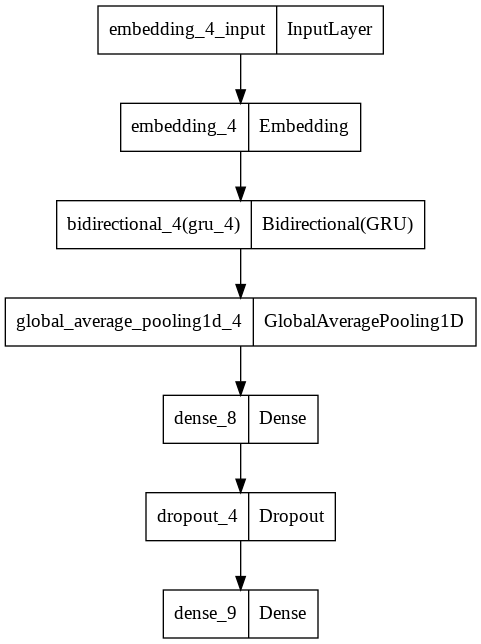

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32567, 286), (2964, 286), (32567,), (2964,))

In [ ]:
from tensorflow.keras.utils import to_categorical # 범주형 데이터 변경

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
# 모델 최적화 (10번의 에포크)
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1018/1018 [==============================] - 1525s 1s/step - loss: 0.9360 - accuracy: 0.5376 - val_loss: 0.7392 - val_accuracy: 0.6741
Epoch 2/10
1018/1018 [==============================] - 1389s 1s/step - loss: 0.5890 - accuracy: 0.7738 - val_loss: 0.4894 - val_accuracy: 0.8138
Epoch 3/10
1018/1018 [==============================] - 1391s 1s/step - loss: 0.3338 - accuracy: 0.8923 - val_loss: 0.4387 - val_accuracy: 0.8482
Epoch 4/10
1018/1018 [==============================] - 1441s 1s/step - loss: 0.2293 - accuracy: 0.9301 - val_loss: 0.4728 - val_accuracy: 0.8431
Epoch 5/10
1018/1018 [==============================] - 1407s 1s/step - loss: 0.1662 - accuracy: 0.9496 - val_loss: 0.5325 - val_accuracy: 0.8381
Epoch 6/10
1018/1018 [==============================] - 1407s 1s/step - loss: 0.1307 - accuracy: 0.9590 - val_loss: 0.6728 - val_accuracy: 0.8283
Epoch 7/10
1018/1018 [==============================] - 1371s 1s/step - loss: 0.1070 - accuracy: 0.9659 - val_loss: 0.7204 -

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is:- 97.71240949630737 %
Loss 6.75041526556015
Accuracy on validation data is:- 80.39811253547668 %
Loss 99.47479367256165


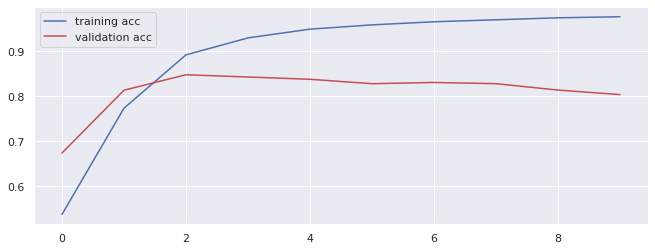

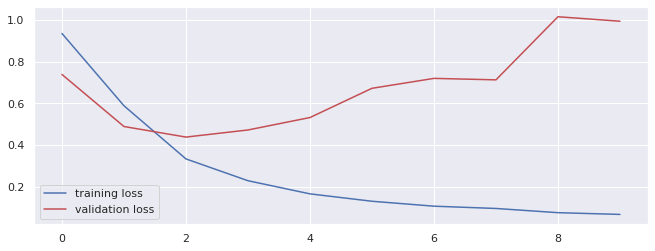

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [ ]:
temp = model.predict(x_test)
pred= np.argmax(temp, axis=1)

In [ ]:
cm = confusion_matrix(np.argmax(y_test,1),pred)
cm

array([[ 387,   47,   63],
       [ 100,  955,  152],
       [  93,  126, 1041]])

In [ ]:
# confusion matrix로 평가 점수 확인, 정확도 80%
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       497
           1       0.85      0.79      0.82      1207
           2       0.83      0.83      0.83      1260

    accuracy                           0.80      2964
   macro avg       0.78      0.80      0.79      2964
weighted avg       0.81      0.80      0.81      2964

